# Getting training data for translation

> "Build our training data using the annotations we brokedown and the genome sequences we've stored."

We need to know which sequences of DNA create which sequences of protein.

A gene can be made up of multiple coding and non-coding sequences.

Our training task is translation from genomic DNA (skipping transcription) to protein sequences.

This means that some sections of genomic DNA will produce no protein sequences and others will, even within the same gene.

I also have to plan around the fact that I have limited computing resources, and I may not be able to train a model with sufficient window size to encapsulate an entire gene.

With this in mind, we need to be able to flexibly get training data where we can slice genomic dna at any location and get the protein sequences that slice is responsible for creating.

I.E.

Gene X has a sequence of 1,000 base pairs.

There is a coding sequence from bases 0 to 100 and from 200 to 1000.

What does the training data look like if we sliced gene X from;

1. positions 0 to 100?
2. positions 0 to 150?
3. positions 150 to 300?
4. positions 500 to 1,000?

In [ ]:
#| default_exp features.annotations

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm
from Bio import SeqIO, Entrez
from Bio.SeqFeature import SeqFeature, FeatureLocation
import re
import json
from multiprocessing import Pool
import os
import sys

pd.options.mode.chained_assignment = None

/home/jdb/projects/llm-mito-scanner/venv/lib/python3.10/site-packages/Bio/__init__.py:138: BiopythonWarning: You may be importing Biopython from inside the source tree. This is bad practice and might lead to downstream issues. In particular, you might encounter ImportErrors due to missing compiled C extensions. We recommend that you try running your code from outside the source tree. If you are outside the source tree then you have a setup.py file in an unexpected directory: /home/jdb/projects/llm-mito-scanner/venv/lib/python3.10/site-packages
  warnings.warn(


In [ ]:
#| hide
from io import StringIO
from yaml import safe_load

tqdm.pandas(ncols=80, leave=False)

with open("../config.yml") as f:
    config = safe_load(f)

In [ ]:
#| hide
data_path = Path(config.get("data_path"))
annotations_path = data_path / "annotations"
genome_path = data_path / "genome"
sequences_path = data_path / "entrez_genes_sequences"
protein_path = data_path / "protein"
if not sequences_path.exists():
    sequences_path.mkdir()

Entrez.email = config.get("email")
Entrez.api_key = config.get("nih_api_key")

## Get gene annotations

In [ ]:
#| hide
test_annotation_file = annotations_path / "NC_000014.9.csv"

In [ ]:
#| hide
test_annotations = pd.read_csv(test_annotation_file)
test_annotations.sample(5)

,seqid,source,type,start,end,score,strand,phase,attributes
104851,NC_000014.9,Gnomon,exon,93634521,93634637,NaN,+,NaN,ID=exon-XM_047431627.1-31;Parent=rna-XM_047431...
130722,NC_000014.9,Curated Genomic,D_gene_segment,105881034,105881053,NaN,-,NaN,ID=id-IGHD1-26;Parent=gene-IGHD1-26;Dbxref=Gen...
113692,NC_000014.9,Gnomon,CDS,99907638,99907733,NaN,+,0.0,ID=cds-XP_047287024.1;Parent=rna-XM_047431068....
128553,NC_000014.9,Gnomon,mRNA,105300774,105398147,NaN,+,NaN,ID=rna-XM_017021112.3;Parent=gene-PACS2;Dbxref...
64415,NC_000014.9,BestRefSeq,exon,64775125,64775403,NaN,-,NaN,ID=exon-NM_001355437.2-23;Parent=rna-NM_001355...


In [ ]:
#| hide
test_annotations.iloc[0, :]

seqid                                               NC_000014.9
source                                                   RefSeq
type                                                     region
start                                                         1
end                                                   107043718
score                                                       NaN
strand                                                        +
phase                                                       NaN
attributes    ID=NC_000014.9:1..107043718;Dbxref=taxon:9606;...
Name: 0, dtype: object

In [ ]:
#| export
def parse_annotation_value(annotation_value: str):
    """
    Handle multiple values in the attribute.
    Return value if list or dict if key-value pair
    """
    annotation_split = annotation_value.split(":")
    if len(annotation_split) == 1:
        return annotation_value
    return {annotation_split[0]: annotation_split[1]}


def parse_annotation_attribute_values(attribute_values: str) -> object:
    """
    Detect if an attribute value is really a dict or list.
    """
    value_list = attribute_values.split(",")
    if len(value_list) == 1:
        return attribute_values
    parsed_values = [parse_annotation_value(value) for value in value_list]
    # Dict within a list
    if ":" in value_list[0]:
        attribute_values = {}
        for parsed_value in parsed_values:
            attribute_values.update(parsed_value)
    # Just a list within a list
    else:
        attribute_values = parsed_values
    return attribute_values


def parse_entrez_gff3_annotation_attributes(attributes_str: str):
    """
    Convert attribute string to parsed attribute dict.
    
    Split on ';' to get attributes.
    Values can also be nested as a dict or list.
    """
    attr_list = attributes_str.split(";")
    attr_dict = {
        k: parse_annotation_attribute_values(v) for k, v in [attr.split("=") for attr in attr_list]
    }
    return attr_dict

In [ ]:
#| hide
test_annotations.loc[:, 'attributes_dict'] = test_annotations.attributes.apply(parse_entrez_gff3_annotation_attributes)

In [ ]:
#| hide
test_row = 0
display(test_annotations.iloc[test_row, :-2])
test_annotations.iloc[test_row, -1]

seqid     NC_000014.9
source         RefSeq
type           region
start               1
end         107043718
score             NaN
strand              +
phase             NaN
Name: 0, dtype: object

{'ID': 'NC_000014.9:1..107043718',
 'Dbxref': 'taxon:9606',
 'Name': '14',
 'chromosome': '14',
 'gbkey': 'Src',
 'genome': 'chromosome',
 'mol_type': 'genomic DNA'}

### Summary:

For each annotations document:
- Read it as a csv via pandas
- Parse the annotations column
- Return dataframe with annotations_dict column

## Converting annotations to SeqRecords for training.

Genes are made up of multiple elements.

- Genes
    - Entire DNA sequence encoding the information for a protein.
- Introns
    - Sections of DNA ignored during transcription.
- Exons
    - Sections of DNA included in the transcription product.
- UTRs (Untranslated Retions)
    - Sections of mRNA ignored during translation.
- CDS (Coding Sequence)
    - Sections of mRNA that are translated to protein.

    
The annotations we have include all this information. Lets extract a SeqRecord object using the annotations that has all this information.

Transformation plan:

1. Filter gff features to those belonging to a gene
2. Create the initial SeqRecord from the feature with `featuretype='gene'`
3. Collect all features with geneID belonging to SeqRecord from [2] (for each)
4. Annotate SeqRecord with features
5. Write SeqRecord with features

In [ ]:
#| export
def get_gene_id_from_attribute_dict(attribute_dict: dict):
    dbxref = attribute_dict.get("Dbxref", {})
    if isinstance(dbxref, str):
        return None
    elif isinstance(dbxref, dict):
        return dbxref.get("GeneID", None)
    else:
        return None

In [ ]:
#| hide
test_annotations.loc[:, 'annotation_id'] = test_annotations.attributes_dict.apply(lambda d: d.get("ID"))
test_annotations.loc[:, 'gene_id'] = test_annotations.attributes_dict.apply(get_gene_id_from_attribute_dict)
test_annotations.loc[:, 'protein_id'] = test_annotations.attributes_dict.apply(lambda d: d.get("protein_id"))
test_annotations.loc[:, 'parent_annotation_id'] = test_annotations.attributes_dict.apply(lambda d: d.get("Parent"))

test_annotations.head()

,seqid,source,type,start,end,score,strand,phase,attributes,attributes_dict,annotation_id,gene_id,protein_id,parent_annotation_id
0,NC_000014.9,RefSeq,region,1,107043718,NaN,+,NaN,ID=NC_000014.9:1..107043718;Dbxref=taxon:9606;...,"{'ID': 'NC_000014.9:1..107043718', 'Dbxref': '...",NC_000014.9:1..107043718,None,None,None
1,NC_000014.9,RefSeq,centromere,16000001,18173523,NaN,+,NaN,ID=id-NC_000014.9:16000001..18173523;Note=Line...,"{'ID': 'id-NC_000014.9:16000001..18173523', 'N...",id-NC_000014.9:16000001..18173523,None,None,None
2,NC_000014.9,Curated Genomic,pseudogene,16024658,16025641,NaN,+,NaN,"ID=gene-DUX4L48;Dbxref=GeneID:107105251,HGNC:H...","{'ID': 'gene-DUX4L48', 'Dbxref': {'GeneID': '1...",gene-DUX4L48,107105251,None,None
3,NC_000014.9,Curated Genomic,pseudogene,16028061,16028716,NaN,+,NaN,"ID=gene-PCMTD1P6;Dbxref=GeneID:107105255,HGNC:...","{'ID': 'gene-PCMTD1P6', 'Dbxref': {'GeneID': '...",gene-PCMTD1P6,107105255,None,None
4,NC_000014.9,Curated Genomic,exon,16028061,16028716,NaN,+,NaN,ID=id-PCMTD1P6;Parent=gene-PCMTD1P6;Dbxref=Gen...,"{'ID': 'id-PCMTD1P6', 'Parent': 'gene-PCMTD1P6...",id-PCMTD1P6,107105255,None,gene-PCMTD1P6


In [ ]:
#| hide
# How long are these coding sequences anyway?
test_annotations_cds = test_annotations[test_annotations.type == "CDS"]
(test_annotations_cds.end - test_annotations_cds.start).describe()

count    52792.000000
mean       162.975924
std        259.262548
min          0.000000
25%         82.000000
50%        120.000000
75%        170.000000
max      16736.000000
dtype: float64

In [ ]:
#| hide
gene_to_protein_map = test_annotations[['gene_id', 'protein_id']].dropna().drop_duplicates().reset_index(drop=True)
gene_to_protein_map.sample(5)

,gene_id,protein_id
3393,123096,NP_001278742.1
1667,317761,XP_011535005.1
209,6297,XP_011535366.1
2713,63894,NP_071350.2
2842,23768,NP_001333073.1


<Axes: xlabel='protein_id'>

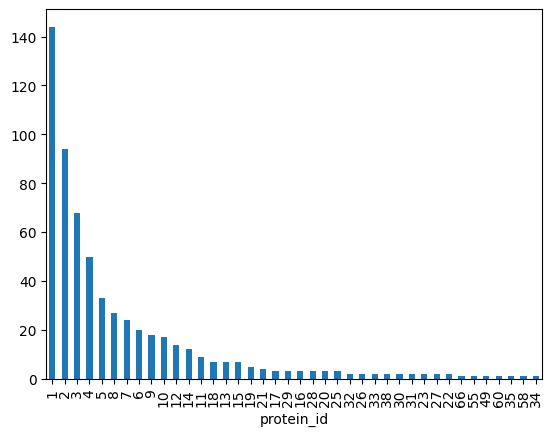

In [ ]:
#| hide
# The number of gene ids with **x** protein_ids. 
# I.E. x = 1 and y = ~140 means there are 140 gene ids with one protein.
gene_to_protein_map.groupby("gene_id").protein_id.nunique().value_counts().plot(kind='bar')

In [ ]:
#| hide
genes_that_encode_protein = gene_to_protein_map.gene_id.unique().tolist()

In [ ]:
#| hide
test_gene_annotations_df = test_annotations[test_annotations.gene_id.isin(genes_that_encode_protein)]
test_gene_annotations_df.shape[0]

118010

In [ ]:
#| hide
test_gene_reference_sequence_id = test_gene_annotations_df.seqid.values[0]
test_reference_sequence_path = genome_path / f"{test_gene_reference_sequence_id}.fasta"
test_gene_reference_sequence = next(SeqIO.parse(test_reference_sequence_path.resolve(), "fasta"))

In [ ]:
#| export
def get_sequence_from_file(
    start: int, end: int, strand: str = "+", 
    sequence_record: SeqIO.SeqRecord = None, fasta_path: Path = None) -> SeqIO.SeqRecord:
    """
    The Fasta file at fasta_path is a single record.
    If strand is positive, index and return sequence.
    If strand is negative, reverse the index and return.
    """
    if sequence_record is None and fasta_path is None:
        raise ValueError("Both sequence_record and fasta_path cannot be None")
    if sequence_record is None:
        sequence_record = next(SeqIO.parse(fasta_path.resolve(), "fasta"))
    selected_sequence = sequence_record[start - 1: end]
    if strand == "-":
        selected_sequence = selected_sequence.reverse_complement()
    return selected_sequence.upper()

Plan is;

1. Group on gene_id
2. Build initial "source" gene sequence record
3. Identify "groups" of feature rows by their parent-child references
4. For each group of features, create an annotated sequence

In [ ]:
#| hide
test_gene_id_groups = test_gene_annotations_df.groupby("gene_id")
test_gene_id_group_id = list(test_gene_id_groups.groups.keys())[0]
test_gene_id_group = test_gene_id_groups.get_group(test_gene_id_group_id)
test_gene_id_group.head()

,seqid,source,type,start,end,score,strand,phase,attributes,attributes_dict,annotation_id,gene_id,protein_id,parent_annotation_id
71949,NC_000014.9,BestRefSeq,gene,70583221,70600655,NaN,-,NaN,"ID=gene-MED6;Dbxref=GeneID:10001,HGNC:HGNC:199...","{'ID': 'gene-MED6', 'Dbxref': {'GeneID': '1000...",gene-MED6,10001,None,None
71950,NC_000014.9,BestRefSeq,mRNA,70583221,70600655,NaN,-,NaN,ID=rna-NM_001284210.2;Parent=gene-MED6;Dbxref=...,"{'ID': 'rna-NM_001284210.2', 'Parent': 'gene-M...",rna-NM_001284210.2,10001,None,gene-MED6
71951,NC_000014.9,BestRefSeq,exon,70600616,70600655,NaN,-,NaN,ID=exon-NM_001284210.2-1;Parent=rna-NM_0012842...,"{'ID': 'exon-NM_001284210.2-1', 'Parent': 'rna...",exon-NM_001284210.2-1,10001,None,rna-NM_001284210.2
71952,NC_000014.9,BestRefSeq,exon,70597618,70597777,NaN,-,NaN,ID=exon-NM_001284210.2-2;Parent=rna-NM_0012842...,"{'ID': 'exon-NM_001284210.2-2', 'Parent': 'rna...",exon-NM_001284210.2-2,10001,None,rna-NM_001284210.2
71953,NC_000014.9,BestRefSeq,exon,70596611,70596702,NaN,-,NaN,ID=exon-NM_001284210.2-3;Parent=rna-NM_0012842...,"{'ID': 'exon-NM_001284210.2-3', 'Parent': 'rna...",exon-NM_001284210.2-3,10001,None,rna-NM_001284210.2


In [ ]:
#| export
def get_gene_row_from_annotation_group(annotations: pd.DataFrame) -> pd.Series:
    gene_rows = annotations[annotations.type == "gene"]
    if gene_rows.shape[0] == 0:
        raise ValueError("There are no 'gene' rows")
    elif gene_rows.shape[0] > 1:
        display(gene_rows)
        raise ValueError("There are more than 1 'gene' rows")
    gene_row = gene_rows.iloc[0, :]
    return gene_row


def get_row_sequence(
    sequence_row: pd.Series, 
    reference_sequence: SeqIO.SeqRecord
) -> SeqIO.SeqRecord:
    """
    """
    sequence_record = get_sequence_from_file(
        int(sequence_row.start), int(sequence_row.end), sequence_row.strand, 
        reference_sequence
    )
    sequence_record.id = sequence_row.annotation_id
    sequence_record.annotations = sequence_row.attributes_dict
    return sequence_record

In [ ]:
#| hide
test_gene_id_group_gene_row = get_gene_row_from_annotation_group(test_gene_id_group)

In [ ]:
#| hide
test_gene_id_group_gene_sequence = get_row_sequence(
    test_gene_id_group_gene_row,
    test_gene_reference_sequence
)

In [ ]:
#| hide
test_gene_id_group_gene_sequence

SeqRecord(seq=Seq('GTAAACGCTCTCGGAATTATGGCGGCGGTGGATATCCGAGGTATACTGTATTGC...ATA'), id='gene-MED6', name='<unknown name>', description='<unknown description>', dbxrefs=[])

In [ ]:
#| hide
# validate extracted gene_sequence
validation_str = StringIO("""
>NC_000014.9:c70600655-70583221 Homo sapiens chromosome 14, GRCh38.p14 Primary Assembly
GTAAACGCTCTCGGAATTATGGCGGCGGTGGATATCCGAGGTATACTGTATTGCTATATTTTGTCTCTTG
ATTGTCTGTGGACCAGTTTGGGATGTTATAGCTCGCGGTTTCAAGGTTTAGGTTCCTTTGTGTGAAGTCT
CAAGCTTTTTTGAGTGGTTTTTGTGGACAACCCAAGGCTGTGATCTAGCGAAACGTTGACGAGTTTTTTT
TTTTTTCTGAGTTCTTGGAGCGTCTCTTGGAAGCGTCGGAGAGAAGGGGTTGGAAGAAGCTCTGGGTTTT
GAGCTTTCAGAGCTGGAGTTTTGTTCTACACACGTATCTCTGCAACAACATTAGGGCTATTCTATTGGAG
TGAAGGAATGGCGTTTAGGCAGAGAAGGGAATGGGGTAATAAGCCAACTTGATTTGATTCATCTCTTGGG
ACTTGGCATGGTGGCTGCCTAATTCTTTAGACCGCGCCACACGGGTCCCTGAGCATGAATCCCAGATATT
TTCTTTTTTTTTGAGTCGATAATACTTTACATCGAACGTCCAGCAATTATTATGGGCAGGGGTCGTATTT
TTTTCACAGCTGAACTGCAGAAGTACTCAAATATTGAATCAGTCAGTGAATAAATGTATGGAGATGTCAC
CCCTTAACTGCTGCTTGATCTTGGGGAGCATGTAGAGTTGTTTTTGTGTATATAGTACTTGATTTTTAAA
GGGAGATGTTTGAGATGCCTTTTTTTAATATTAACTGGATTGGGGTCTAACACATTTATTACAAATATTC
TCATTTATACTTATCTGGCGATCTGCAGCACTTCTGGATCATGATTTTACATACGTGTCTTTCATTATTT
ATTTCATCACTTGCTGATGGTTAGAATGCTGTTAGAATGCTTGGGCTATGTCAACATGTTGCCTTGCTAC
AGAATAAAAAAGAGAAATATTTAGTTTATAAAATGTTTTACTTATAATTCAGATTGTTAGGATCATGGCA
AAGACTCTAAAATAAGAGTGTGTTTGGTGTGTTAAAGGAACAGCAAGGAGGTCAGTGTGGCTGGAGGGTA
GTGAGAGAGGATGTGGGAAGGAGATGAAGTCAGAAAGGTGTTGAAAGCTATGATAAGGTCTTTGGCTTTT
CCTCTGAGTAAAACGCAGAGCCATTGGAGGGGTTTCCATCAGAGGAATGATGTGATCTGACTTTTTTTTA
GGACTACATTGGCTGCTGGGAACAGTGTAGGAGGGCAAGGGTAGAATTAGGAAAACCAGTTAGGAGGCCA
TTTCTGAAAATGTTATTTCCTGGCCTGTTGTGTATTTGGTTATTGCATGATCCAGTTATGATGAACTATC
TAAATGGTCTATACTAATTATTTGGTTATTAACGCACTTCATCTGTCTCCTCCTTTATTTTATAGCACAC
AAAGTACATTTTACCTTTATATAATTTTTCTCGGTTGAGTCACTTGGCTCAAAACTGCCTGTCACCTTGA
ATTAGGTCTGACTTCTTTGAAGATGCCTGAGGTAATGACAGTATAAGAGAGATTGAAGTTTTTCAACCAG
TATTGTATAGGCATTTTGATGTTCATGATTTACACCTAGTGGTGTTCAGTACAGTCAGTGGTATGAAGCA
TCATGAAAGCCAATAGCCAATACAAGCTCATTTATTAAAAGTATCTAGCTCTATCATGTCTTTTTAAAAG
CTATGATTTAATTCTACGCTAAATATGAAACCGTGTGGCTGTAGTTAAGGGAACTCTACTTCCTGTTTAT
CCCTTAGCTTTTACATCATTATCATCTCATCTACAATAATAGCTTCCTAACTTCTCTATCCCTAATTGAG
AGATCTCAAACTGGTAGCTATAGATGTGTTCTCTTGGGCATACATGTTATTTGAAAATTTTGAATTCCTT
GCCAGCATTAAGGATTTCCAATAAAAAAAAAAGTCCTTTCTAAATTTTAAATCTTATCACTTCTTCACCT
AATGAAATTATTCTCTAAAGATATAATATACTTTATATTTTTACACCTCTGTATATACATTCTCTCTGCT
TGGAATTACTTTGCCCTTTTCTCTGTGTAAGTTTTTATTTATTCTTTAACATACCGTGCTAAAACCCACC
TTCTCTCCACATGAAAAATGATTTTCGTTTCCCCAGGTCCTCTGTAGTCTCGTAACACATTTCTTCATGT
CTTTTTTTTTTGAGACGGAGTCTCGCTCTGTCGCCCAGGCTGGAGTGCAGTGGCGCGATCTCAGCTCACT
GCAACCTCCGCCTCTTGGGTCCAAGTGATTCTCCTGCCACAGCCTCCCGAGTAGCTAGGATTACAGGTGT
CCACCACCATGCCCGGCTAATTTTTTGTTTTGTTTTTTTTCTTTTTTTGAGACGGAGTTTCACTCTTGTT
GCTCAGGCTGGAGTCCAATGGTGTGATCTCGTCTCACCACAATCTCCGAGACCTTCTGGGTGCAAGCGAT
TCTCCTGTCTCAGTCTCCCAAGTAGCTGGGATTATGGGCATGCACAAACACGCCAGGCTAATTTTGTATT
TTTAGTAGAGACGGGGTTTCTCCATGTTGGTCAGGCTGGTCTCAAACTCCCAACCTCAGGTGATCCACCT
ACCTCAGCCCCCTAAAGTGCTGGCATTACAGGCTGAGCCACCGCACCCGGCCAGAATTTTTTGTATTTTT
AGTAGAGACAGGGTTTCACCATGTCTTTATCATAAGACTTAATCATGTTATTGCTTTCTTGCATAATCTC
TTCTGTTACATCATGAGAGTGTGTTGGTTAGGATCTATGTCATCCTTATATTCATAGTGCCTACTACATT
TGATGTATAATAAATGTTTGTTGGATTGGATTCTTTCTATTTTTCTAATCCTTTATCATTTTGTTTTCTT
TCCCATAGACAATCTGCTGGGAATTTCTTGGGTTGACAGCTCTTGGATCCCTATTTTGAACAGTGGTAGT
GTCCTGGATTACTTTTCAGAAAGAAGTAATCCTTTTTATGACAGAACATGTAATAATGAAGTGGTCAAAA
TGCAGAGGCTAACATTAGAACACTTGAAGTAAGTTATTTTAAGAAGGTGGCACTTTTTCCAAATACAAGT
TTTGCAATGAACAGTTCTTTCAAACTGTGGATCATGAAGTGCAGAGTAGAACTTTTAGAAGAAAAACTGG
AGTTTTGTTTGGGTTTATGCAAATTTGACATGCAGGGTAACTATTAGTATTCACTTTTAACAGAGGTCTT
TTCTGTATAACTTCATAATGTTTAATTACAATATAACAGGTTTAGATTTGGATCTGATGAGTGATTTTGG
CAATGCTACTGTTATTCTCAACCAGGCAACTATAATTATTGTCTCTTTTATATCTAGTTTATATTACAAA
AGTATTTGAAACAACTGTTGATATAATTTTCCTGTTAGCTACATATTGAGGAGGAGCTTATAAAATTAAA
TATCTGTTATATTTTAAATGGCTTTTGTTATGGGGCAAATACAGCTATTGAGACAACTTATTGTTGCTTT
TAAACATAATCTGTCAGGTAAAAAAATTTGTTGGGATGAGGATAAAGTTTTTGATGTTTTCTAGTTTGGT
AATATATATAGTTGTGTCTTCATGTTTATTTTTATATTTTGTATGTATTCGTAGATTTGGTCAGGAAGCA
TCATGGCATTTTGATTGCCTTTTTGAAACGGACACTCTTTGGTGTACTTTCCTGACTGAAAATACTTAGA
TTTAAATTTATAATACATTGTTGTAGAGAAATTTTGTTGTTTAGAAACAAGTCTTACTTTATCTATATGC
CACCTGTCTGGGAAAACAGCCAATTTTACTCAACAGCCAGATTATAACACCAAACATAGGCAGTTTTAAT
CCTATTTAAAGTGTTGCTGCATTTTTATATAATAATTTGAATGTCTTATAAAATTATTTGTAGGGCGTTT
ATAGATCTTTGGATGTCTGTGTTCTGTTTTCAGTCAGATGGTTGGAATCGAGTACATCCTTTTGCATGCT
CAAGAGCCCATTCTTTTCATCATTCGGAAGCAACAGCGGCAGTCCCCTGCCCAAGGTAAAATGTGTAAAC
TTTAGGCATTGTTTTCTTTTTAAAATACCATAATTTATTTACTTCCTGACCTAACTTGTTTTTTTGATTG
GTTTCTGTTTGGGGGGTCTCCAAGACCACATACATGTTCAGTACTATGCTGGAGGACTCACCAGACTTAG
CATATGGTTGTACTTACAGCTAAGATTTGTTATGACAACACAGTAAGGGTACGCAGCCAGATTAGTACTG
GAAAAAGACATGTCAGGTGGGGTCTGTAGGAATCCATGTGCAAGTTTCTTATGCTTTCCCTCTTGCTTGT
GAAGGGCCACAGAGTGTGCCCTCCATCCAGCAGTGAAATGCAGCTGCATTCAATATGTCTGCTCAGGGAA
GTCCATATAAGACTCTGAGCCAGGGATTTTTATAGAGGGTTGGTTGCTTGGACATCCTCTGCCCACCAGA
TTTTTAGATTTTCCAAAAGAAATCTGGTGTCTACTATAATCACATTGTTTGTACAAATTGTCTGCAAAGG
CTGGTACAACCAGCCTAACTATCATATAGGAAATGTTTCAAAAGCCAAGTTCCACTAGTTGTATACTTGG
ATACCAGGACTCTTGGAGCATGCCCAAGGACAACTCTTCAAGCACTAACAGTCAGAGCGACTCACTGCAT
CAAAGCTACCTCTTTCTGTGAGCACAGTTGGTATACCGACTGAACGTCAAGCATCCCAAGTAATTTTGTT
TTGTTTTTTGACCTCTGAACTTTTTATTGGCCTCCTGCTCCTCAAAGGGTACCCTGCTTCTGCTGGCTTA
ATGTCTCAGAATTTTGATGTTGTTGGTCTCAGACACCACTCTGCCATCCACTACCTGGCGGGTGGGGTCT
TTTGGATGGTTTGCATGGAGTTGCTGCTGTCCAGGGCGTCACCAAGATTGAAGTCCTGGCTGTCTTCCAG
CAGGCGGCGGTAGGTGGTGATCTCAGCCTACAGCTTGACCTTGATGTTCAGCAGGGCCTTGTACTCCTGG
GCCTGGTGCTGCCTCTCTGCCCCGGCCTGTGCCAGCTCCAACTCCAGGTACAGCAGGATCCTGTTGAGCT
GCTCCATCTGCAGGGTATAGCAGGCCTCCACCTCCCTCAGGCTGTTCTCCAAGCTGGCCTTCAGATTTCT
CATCGAGTCCAGGTCAGTCTCCAAGGACTGGACCGTACCTCTCAGCTCCGTGAGCGTCACCTTAGCAACC
CCAACCTTGGCAGACTGCATAGTGACCACTGTGGTGTTCTCCTCAATCTGCTGAGACCAGTACTTGTCTA
GCTCCTCTCAGTTCTTCTGAGCCAGCTCTTCGTATTAGGATGTCTCCTGTGATCTTGGCGAGGTCCTGAG
ATTTGGGGGTATCTACCTTCATCGTCAACCCAGAGCTGGCAGTCTGGGCTTGTAGGCCTTTACTTCCTCT
TCACGGTTCTTCATGAAGAGCAGCTCCTCCTTGAGAGCCTCAATCTCTGTAGCTGAAGCCGAGTGACACT
GGTGTCATTGACCTTGCAGAGCCCATGGATGTTGCTCTCCACAGACTGATACATGGCCAGCTCTGTCTCA
TACTTGACTCTATCAGCAGCAAGATGGGCATTGTCGATCTGCAGAACAATGTGGGCATTGTCCACAGTAC
TTGAGAAGATCTGAGCCCTCAGGTCCTCGATGGTCTTGAAGTAATGGCCCCAATCTCTGACCTGGGGTCC
CTTCTTATCCAGGTGCTCCTGGATTTTGCTCTCTAGCCTCTGGTTCTCGGTCTCCAGGCTCCTCACTCTG
TCCAGGTAGGAGGTCAGGCATTGAACCAGGGTAGGTTCAGGCTTTGCATGGTCTCCTCCTCGTTCTGGAT
GCCTCCCATTCCTGCTAGAACCCTGGCCATCCCATGGCCAGGCTCCTGTACCCCAAGCTGCCCTGGAAAC
CGGTGGAGCGGGACACGGAGATCTGGGAACCAGAGCCTCCGGTGCCTGTATAGACGCTGGCCGTGCTGCT
GACTGGCTGGGTGCCGCAGCTGGGCGCCTGGATGGAGCCCAGGGACCAGTAGTTGGAGAAGGTGGAGTGA
GTGGTGAAACTCATGCTGTCTGGGGAGGAGAGTGAGAGGACAGGACTCAGGCTTTGCTGATGACCACAAT
TAACTTTTTTTTTCACATCAGTCCACTGAGTTAATTCTTTTACAAAATGCATGGTAGATCTGGTCATATC
AAATTAATAGAGGATCAGTTGAAAATCCTCAGTGATGCATTCAACTAAAAGCCTTGCGTGGGTTATACTA
CCTACTGAAAGCTTGGTTTAGAAACAACACTGAAGAGTGTAGAGTCCAGATTTGGTTTTGAATCAAAGAG
CTAGACACCTTTTCCAGCGATGACCAGAAATTGAAGACATTAGAATCAAGGCAAGACCATGGATAAAGTC
ATACTGAAGAGAAGATTCAAGATAGGGGAGCCAGATGGGTGTTATTCTAGCTACATCTCTCAATTGGATA
CCCTCATTAAGACATTTATGGACAATCTTTAACTTGGCATTGTTTTCAGAGAATGACTTGATAAAGAAGT
TGTGATTCTGGAATCCAAAATCAGTTACAAAATCAAAGATCTAGAGTCCCTGCCCAGAGTAAAAGAGAAC
CTTAGAACCAAGGCAAACCAGCGACAAGACAAGATTTCCATAGTGAGAGGATTCAAGGTGTAAAAATTAC
ACAAGACGGCAGTAGCCTCACTAGCAGCTATCTTATTCCTTAGGACCCAGCACTGGGGCACAAAAGCAAG
CTCATTGCATTTGATATCTTTACACTGGACCCCCCAGTCTGTCTTGCTCCAAGGTCTTACTCCCTTAAGT
AAGGTTGACTGACAACAGTATTGGCATCTTTTGGGAACTCGTTAGAAATGCACTATCCCTACTGAATAAG
AATCTAATTTTAACAAGGTCCCCAGGTAATTCAGATGCACATTAAAATTTGAGAAGCACTGCTGGAGGGC
AACAGTGGGCATACTTTTTCTGAAAAGGGCCAGTGACTAAATACTTGGGGTTTGTGGGCCTCGTAGTCTC
TGTGACAATGCTCAATTATTGCCAGAGCAGCCATAGATAATATGTAAATGATTGGATGTGGCTGTTTTCT
AGTACAGCTTTACCAAAACAGTAATTGCTAAACCCTGCCTTATGGGAAAATGTCAGATTTTATTTCTTTT
TATGAGAATCTGTTTAGCAGTTTGTGTCCATAGCTGTATTTATAAACCTTTTTTCCCACTGTTTTAGTTA
TCCCACTAGCTGATTACTATATCATTGCTGGAGTGATCTATCAGGCACCAGACTTGGGATCAGTTATAAA
CTCTAGAGTGGTAAGTGTCTTCACATTCTTTAAGCACTAAAGAAAACTTTTAATTAGCTACCTTGCTTCC
AGTAATCAAACTAGAGCTCCTCTGCCTTGTGTAAGTTGCTATAAAGTATTGACTATTAGAATGTCTTGAA
CTTTGGTTACTGTGAGCCAAGTCGGTGCTCAAAGTATATTTCATAGTCTCAATTATATAGTAATTTAGGT
TCTGAAAAATAGGTTCTGTCTTTGCATATGTAATATTTTGTGAGTATTTACTTTGGAAAGTTTGGTCGAC
CTAATGATAAATTTAGAGTTTATTTTCCTTTTACAAGCTTACTGCAGTGCATGGTATTCAGTCAGCTTTT
GATGAAGCTATGTCATACTGTCGATATCATCCTTCCAAAGGGTATTGGTGGCACTTCAAAGATCATGAAG
AGCAAGGTAAGTAGAACATCCATACCCTCCTAAAACACTTTTTGATCCTCTGAGAATGAAGCTGTTTTCT
TTAGGAAAATGGCTGTTGATCTTTTCTAAGTGTGTTTCACTTTTTCATGGGATGATGGCTTTGTTGCAGC
TGAGATTCATGTAACTAGATGTGGTAATAATAGCTTTCACATAGGAACAGATGCAAGTTCACTCTGTTAG
TTAACTGGTAGTCTTTGTTAAGGTGATTCAAGGTTTTAAAATATTTGGGGCCAGGTGTGGTGGCTCACTC
CTGTAATCCCAGCACTTTGGAATGCCAAGGCAGGTGGATCACCTGAGCCTAGGAGTTCAAGATCAGCTTG
GGCAACATAGTGAAACCTGGTCTCTACAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAGGAACATAGGAGA
GACAGTGGTGTGGAATGAGCAGAGATGATATTCCTTACTTACCTGACTGTTGAGTTATCTTGGTATCTGG
AACTCTTTATTCCTCCAGTCTTCAAAGCAGAGGAGATGAGAGAGATTGCTTTTTAGAGCCCTATCCCCAG
ATGGCCAGTCTGTTTTCTGATCTTTGCATCTCATCACCTCTTGTGGCTCCAGGTCCTCCAAGTTTCCATG
TAATCTGCTACTGTCTTCATCATATTTTACTGTTCGACTACCTCCAGAAATGTGCCTGTAACAGCATACT
TGTATTCTCCATTTCCTTTTCTGAGAAATAGCAAGTCAGAATAAATTACTGAGGGAAACAGCATTTGTAT
AGAATTCAGACCTGTATCTTCTTAATAGTAGGTATAAGCAGGAACATTTGATGAAGGAAAGTTTGCCTTT
GTTGACTAAAATTGGCCCAATGGCTCTTTTCCCCTACGATAACCAAGTGTTCGGAGTAACACTTATCTGG
AATCCTTTGCTTAGAGACAGTTTCCCAATACACCTCCCTCCCAAGGGCAAATCCCACATGCGATTAACTT
CAGAATTTCTCTTTCAGGTTCTTTTCTTTTTTGTCTTCATAATTTTCTGTTTTATTATTTTTTTTTAGTG
AATTACAGTCTTAATAATTGAATATGGTAGCTTGAGTTTGTGAAACCTGCATTTCCATTTGTTGCTAGTA
GGTTTTGTGAGAAAAGACCATTTAATACACTTAAAATAACAAAGGTAATTTCAAGCCAATAATTTGGATT
GTGTGATTTAGGTAATTATGAAAAACTTTAGCTTTAAAACTCTTACGGTTGTGCGTGCTTATATACCAAA
ACTGAAGTATCTTTAAAAGACATATGTATCAGCTTAAATGTTAGAATTTAACTTCAGTTAAGAGGGAGAG
TTAACAACACTTCTGTATATGTGCTGTGTTTACCTTATTTTGGGAATTATCTTTGGTATAGCAGCCATTA
AAAATAATGAAGTTTGGGTATATTCATGGTGGATAAAGATTTGTAAAATATGAGACACCAAACTAAGTAG
GCAATGTTTTGATTTGGACTTCGTATTTTAATAGATAAAGTCAGACCTAAAGCCAAAAGGAAAGAAGAAC
CAAGCTCTATTTTTCAGAGACAACGTGTGGATGCTTTACTTTTAGACCTCAGACAAAAATTTCCACCCAA
ATTTGTGCAGGTAATGAGAATATGTGTGGTTAATCTTGATTTGACACTTCTTTATGGCATATATATTAAT
TTTTAATTGAGAACTGTTTCAGATGTGACCTAAAAGTACAATTTTCCTCATTAGTTAAAAAATGATCTCT
GTATCAAAGGAAAGGTTTCGAAAGACTTAATGGAAGAAATGGGTAAATGGAATGGAATTAACACTGTTTT
GTGTTTCTTACTGAAACTTCACAAACTATGAGGACTGCATGTAGATAATATTCTCATTCAAAAGGTTGCT
GAAAGTGTCACAGGTGGTAACAAAACTAGAATATGAAACTCATGCTCTTTTTACTCTACATGCCACCTTC
CAGCCTGATGTAGTAGATATCTGAACAACCTAAATGATAGAATAGTTAACACTTGTGTAACAAAAAGAAC
AGAACATCTGAGGTAGAGTGTTTGGCATAATAAACAGAGGAGACAGGAGTGATGAATAGAGATACCCTGT
GTTGGGGTTTTAAGTTATATGAATTCCACTGTGTGATTTGGAGGGGCAGGGAGATTTCTAACAGCAATAG
CAAATCCACCTGCCATTCTACTAAATGAGCTTTTGGAGTCTAGTAGATATGGAATGGAATAGATGAATAT
GCTGTTCTCATGGCTAGTCTCAATTCTTCTGGACCTTTACAATGTACATACAAGATCATATACCCTGTTT
TTGTTAGGAGCTCTTTAAGGGATTTTCAAGGGAAATTTTAAACTAAATGACATTTTTCACATGAGATGAC
TTTAGAACAAGCCTCCCCTTTTCTCTTCCCTGACTCTGCTGTAGTGAGAGATAGGTGCTATTGGAATTGT
GATGTAGTGGTGAAGAGAGCAGAGGACACAAGATGGAACTCAGGACAGGAAAGCCAGTTTAGAGGAATCT
CATCAACTGCACTTGAAGATGGAACATAGTCTGTTGAATAAATAAATAAATGAATTATAGCTGTAGTAGG
GTGATGAGTGACCTCTACAGAATGTAAGAGGTTAGGTGTAGTTGACCATTCATTTGGTGAGTACATAGTG
TATGCTAGGTAGGCCAGGGGAAGACACCTAGACATGTGCTGTCCAGTATGGTAACCACGAGGCACATGTG
ACTATTAGCATTTGAAACACAGCTAGCCCAGATTGAGTTGTGATGTAAGTGCAGTATACATACTGGATTT
CAGACTTGTATGAAAAAGAATGTATGTAAAATATCTCAGTAGTTTAAAAATATTGATTATATGTTGAAAT
AATATTTTAGGTATATTTGGTTAAATAAAATACATGTTTCTTTTTAAAAATGTGACAAGAAAATTTAAAA
TTACATGTATAGCTTGCATTTGTGGCTCACATTTCTTTTGAACAGTCGTGATCTAGAAAACGGTAATAGA
ACATGCAAAACCAGAAACATGAGTTAGTGAACATATGTTCAGAAACCAGAAGAATCCTCTGAAGGTTTAC
TCTGTGTTTGTGGAGGGGAAGAGTAATGGAAGATGAGACTTAAAAAATGGATTAAGGTCAGTTGAGAAGG
ATTTTGTATGCTATGCAAAGGAGCTGGGATTTAATCCTGGAGGCCTATGTTTCTTCTCTATTTTAAACTT
ACAACCCATTACCACTCCCATAAACATAACAGGCCTCCAGATGCATTCAGAGTTATTTTAAGTTTTAAAC
CAATAGCTATCATAACCAAAGGCAGACCAAACCAGGAGAAATTTTGTATAATGTTTTTCAAGTATATACT
CTAGGAGTGTATTCTCACTAAAAACTCCTCTATCTCATCTTCAAGTGACTAGTTGAGAATTATTGCTGAT
GGTGATAAGGACCCATTGGGTATTTAAAAGTAGTTGCAAGGGAGTGGTGTAGTCAGTTTTGTGTTTTAGG
AATGCAACTAGTAACAGTATGGGGGGGATGCTTAGGAAATCACATGTGAAGTTTGGAGTCAGGGCACTTA
AATTGTGGAAAACTTGAATTCTGTGGCCATAGGATAGAGAGGAGACAGATTCAGGAGGTATTTCGAGTTA
GGATTGCTTTAATTTGGTGGTTGGATTTGGAGAGATTGGACAAAGGGTGATTCTGTGGTTTTAGGCCTAG
AATTAGACTAGGTATTATTAACTAAAATTCAGAATACAGGGAAAGAAACAGATTTTGGTTGAAATAACAG
TTGTTAGGGGTTTGGTTTTCATTGACCGACCTAAAGAACATTCGGTAGTTTGCTGTTGTATTTGAGTCCT
GAGGTACTCCAGTGAAAGACAACTTTTTTTTCCCCGCCCCTGGCTAGGGATGCTGCCTTGATTCTTGTTT
GCTGTCCTGTCCTGGTGAGCTAGGCTAGACGTTATAGAAAGCTCAAAGACTCTCTTGATTCTTAAAATAA
AAACTCTTTACTTTATAGAAAAGTATGGTAATTTTAAAAACATGAAAGCAGAGAGAATAATTAAAAATGA
AACCCCCTCTACCCTTTAGCCTGCCTCAACAGTTATCAAAATGGCCAAGCTTGTTTTATCTCTTCTTCCC
CTACTTCCTCCCAATTATTATTATTATTATTATTATTATTATTATTATTATTATTATTATTATTATTTTT
GAGACGGAGTCTCACTCTGTCGCCCAGGCTGGAGTGCAGTGGCACGATCTCAGCTCACTGCAAGCTCCAC
CTCCCAGGTTCACGCCATTCTCGTGCCTCAGCCTCCTGAGTAGCTGGGACTACAGGCACCTGCCACCACG
CCCGGCTAATTTTTTGTATTTTTTAGTAGAGATGGGGTTTCACCGCGTTAGCCAGGATAGTTTCAATCTC
CTGACCTCGTGATCTGCCCATCTCGGCCTCCCAAAGTGCTGGGATTATAGGCATGAGCCACCGCGCCCGG
CCCCTCCCAATTATTTTTAAGCAGACTGCAGATTTCATATCATTTCAGTGAGTTTTTTACCTTTTTCTTT
TAAAGGTTTAGCCACATTCATACTTATATCATCATATTCCTGAGCCATTTCTTTTACCATCCAAGGGCCA
AAAACCAACTCCCAAAGATAGAGTATATCCAGCTCTGTGTAACATAACTAGGAGAAAGATGGCTTTCTCT
AGAACTATTAATAATCTTTTTGCTTTTCCTAACAAAAATTTTTCCAGCCTCAGATCTAGAGAAGAAAATA
ATCTACTGCAAGTCTCCCAGAACTTCTTTTAGCTCATATGAACTCCTCTTTACCCATTGCATCCTCCAGA
ACTACCTGTAGTTCGGATAAGGATACAGCAGGTATTCCTACTAATCAATTTTATCGAGCAGTTGGGCTTG
TGGTACCCAGGGATGTTGCCCCTGTAAGGGGATGTTCAGGAGAATATTGGAGAAGTCCTGTCTGCTTCTT
TGAAGCTCCTTTTTCCATATTTTAATTCTTGTTACTGCTGGAAGTTGCACTAATACTGATGTGATGAGAG
TTTCAGTCCTTGGAGCCTTTTATGAGGACTGTCTTTTTATTGCTGGTTTTAGAAGCTGCTAGAATACCAT
AGGATATTACTTCAACTAGGATTATCTAAACCAAAGCCACCTGATTAAATTTGCTCCAAGAAGCACTCTT
GTTATATATCCCCATCTCAGACCGTGTTCTACTAGTCTAGCAGGACTTACTAGAAAAGATTAGACAGTGT
ATTATGTTGGGTAAATAATGACATTATTCCAATGTCCAAATATAGTTCAGTGTCCAATATAGTTTAAATG
TAGTTCAGTGCTGACAGTAGAAAAATCCCCCTTTTCAAATTTTTTACTCTCCTCAATGTTCCTCCCTATG
TTTCCTCTCCTATTTTAAAGAAAAACAATTTATTCCCTCAAAATTACTTTGGACATGTTAAGTATTGATA
TTTTCACAAGATAATGTGATATGTGGCTTTGTTGGGGGTTCTCATGATGACTCCCGTATTTGGGGATTGC
TAGCAGGACTCAGAGGACTCAGCATGTAGTTGTACTCAGCTAAGATTTATTGCTATAATATAGCAAGGAT
GTATATAGCCAGATCATAAGGGAAAAGGACACAGCAGAGTCTGGAAGAATCTATGTGCAGGCTTTCTTAT
ACTTTCTCCTTCCCTTAAGAGGTTACACAGAGTGCACTCTTCTCTCAACAGTGAAAATGCAGCAACATAT
GTGTGATATTTCTGCCCAGGGAGATCCATTAGAGACCTGGTACCCAAGGTGTGTTTTTGGAGTTGGGGGA
GCTCTTCATGTAGGTATCCTCTATCTAGCACATACCAAAATTTCACAACCTCTGAAGAAAGCAGGTATTC
AGCCTAAATTGCATTGTTTGTACAGTCTAGGCACAGTGAGCCACTATTACCAGGGAATGGTGGGAACCCT
CCAAAAATCCAAGTTTCTAGACACTAACCAAGGGCCAACCTTGCAAGCAGGCCTTTCTAAGTATAGCAGC
CTCAGGCCTTCTGTGGTAACCTTTTTATTGCACAGTGGATAATAATGTGAAGCTCAGTTTTGGTCTTGTT
AAGTGTAAAGATTCCCAGGACTTGCAGTTGGAGTAGGATAGTTGGCAGTTGTCAGCATGAACCTGGAACA
TGTAATATCAGAAAATTTTGTAGTTAGAAGTGGGAATAGGTAAGAAGGCCTAGGGAGGGCATGTAAATCC
AGAAAGATTCAGCACACAGATGGAGGCATTAGAAGTGAAGAGACTGTTTTTTCTTCTAAGATGATATGGA
AGTAATAAGGTATTTTAAATATATATGTGTATATGTATATAAAGTTATAATAAGTTTGAAGGTAGATGGT
AAGGAAGTTGGTGGTGTTGGCATCCTGGTTTTGTTGTTGTTGTTTTTAAACATGGGAGACAGTGTCATCG
GATGAGGGGTAGAAGAAGACAAGAATGTCGTAGAGCATTTAACTTGGGGAATGGGGCAAAGGAGATGACA
GAGCTTAATCAAGTGAAAGAATTGCTTGCAGAGTGAAGGACCTGACCTTGTTTCTAACCTCTAATGCTCT
TATCTTTTTTTCCTATAGATTGGTTTTTAATAATAGACTCATCAGAAATCTCTTTTCCCTCCAAATTTCC
CATGCCTACCAACTTTAAAAGTCATGGTTCATCCATACTTCATTCTCCCTTCCCATAAGTCATAACCCCT
AAGGAAATAAGACTCTGGGGTATTGAAAGACTTATTATTTCTTCCCATTGGATTCTACTGAACTGCTTTT
TATAAAGCATTGTAGCCTGGGTGTGGAGGTGGAAGTCTTTGTTAAATGTTCAAGTGTTTTTATGGTTGGT
TGACTATCTTGTTCTAGTTTTTGATTTGTGTCTTTTCTGGAATGGGGAATAAGAAGTAGAAAATGATAAA
TTTACTTTATAGTACATACATAGTAGCTTTTCTTCACAAAGTCATTTGAAATGTAATTTGGATGAAGCTT
TCATTTTATTAATATGACATCAGGAAGAAGAAATTTTGCCAAGTTGACCTGTTTTCTTCTTTTTCCTCTT
CCTCTCCCTCCCTTTTTTCTAAAAAATTATAGCTAAAGCCTGGAGAAAAGCCTGTTCCAGGTATGGTTCA
TGTAATATTCTTATTACGCTTGAAATAAGGTCAAACAGCTTGTAAATCAATCACAAGTATAGCATGTGAA
ATGAGCTGTGGTCATTTTGTCCTTCTAGAGCTGGGGCTGGGTCTCATTGGAAGAAGAATTGTCTTGGGTC
ACACATAAAATAACACTAATGATGGCTGATGAGCTGAAAAAAAAAAAAAAGTCTCATAATGTTTTAAGGA
AGTTTACAGATTTGTGTTGGGCCACATTCAAAGCCATCCTGGGCCTCATGCTGCCCGTGGGCGGTGGGTT
GAACAGTCTTGTTCTAGAGTCTCCCATTGTAGTTTTTTACTCTTAATCTTTGAGAGCTGCTGAACTGTCA
GCAGGTGGTGCCATTGTGGTAGTGATTGTGGTAGTGAAAAGATGAATTGGGAGGGAAAAAGTAGGTATTG
AGGAGGTGTGAGGAAGCCACTGTGATTCGAGGTTTCTTCATCAAATCTGTATTTTTACACAATGATGTTT
TCTGTTACATTATTGAAAACAGGTATTGAACCATCATGGTACTGGGTTAGAATAATTATATATCTTGTTT
TTACATACTGTCTTACTTAAATGCTATGTAGTTTTGTCTAGTATCATTAATTTCCTTGAGTTTTCAGGTT
GTTAGGTTTGTAACTGGGTTCTTGTATACATCTGCCTGGGGAAACAGCTAGATCTAGAACTTGAGATAAG
CAGTTAAAAATGAATTTGAAAATGTGAGCCATTCATATTAACCATTTATCTCATTCCCCCCACCCATATC
TCCCTCCCAAAAAATCTACTTTTGATATCTAGTGGATCAAACAAAGAAAGAGGCAGAACCTATACCAGAA
ACTGTAAAACCTGAGGAGAAGGAGACCACAAAGAATGTACAACAGACAGTGAGTGCTAAAGGCCCCCCTG
AAAAACGGATGAGACTTCAGTGAGTACTGGACAAAAGAGAAGCCTGGAAGACTCCTCATGCTAGTTATCA
TACCTCAGTACTGTGGCTCTTGAGCTTTGAAGTACTTTATTGTAACCTTCTTATTTGTATGGAATGCGCT
TATTTTTTGAAAGGATATTAGGCCGGATGTGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCAT
GGCGGGTGGATCACTTGAGGTCAGAAGTTCAAGACCAGCCTGACCAATATGGTGAAACCCCGTCTCTACT
AAAAATACAAAAATTAGCCGGGCGTGGTGGCGGGCGCCCATAGTCCCAGCTACTCGGGAGGCTGAGACAG
GAGACTTGCTTGAACCCGGGAGGTGGAGGTTGCCCTGAGCTGATTATCATGCTGTTGCACTCCAGCTTGG
GCGACAGAGCGAGACTTTGTCTCAAAAAAGAAGAAAAGATATTATTCCCATCATGATTTCTTGTGAATAT
TTGTTATATGTCTTCTGTAACCTTTCCTCTCCCGGACTTGAGCAACCTACACACTCACATGTTTACTGGT
AGATATGTTTAAAAGCAAAATAAAGGTATTTGTATATATTGCTTCATCATGACTTTTTTCTTCATCATAA
CTGATATTTTTCAGATGCACTTTGAAGACATAAAGGATGTTAAAGTAGTAACTAAGCATATTTCTTTTTG
TTCAGTTACATAATCCTCAGTATTAAAATAAACAGTTGCTGACATTTTGGAAGATGAAGAAAAGGAAAAA
CCTCACTCACCAATACCATTACCCTATAAATACTGTAACAGTGTTGTGAATTTTAATCTTATTCTGTGTG
TAGATACTTCTTTTTTCAATAAAGAAAAGGAATTTTATTTTTTTTAAAGTTATGGAGGCTGAGAAGTCCA
GCATTGATTGGCTCCATCTGGTGAGGGCCTTCTTGCTGGTAGGAAGTCTGCAAAGTCCCTAGGCAGCACA
GGGTATCTCATGGCAAGGGGGCTGAGTGTGCTTGCTGCATGTAGATGCTTTTAAAACTGTACTTTAATCA
TTCCTTTCGTACAATTTTACTTTATTATATCTGTTGTAAGCTTTTCCCCATGTTTATGTAGTTTTTATAG
ACTGTTTTAGTGTCCGAATTTCTGTAAATGATTGTATCTCAGTTTTCTTTCTGTCTTATATTTGGGATTT
TTCCCAGTTTACATTATTTTATATAAGACTGCTGTGATTATATCTTTGTATAATGCCTTTTCAGTGTTTG
GTATTTATTTCCTTAGGATAGAGTTCCAGAAGTGGAATCACTAGAGTCTCTGCATTTTTATTGCTCTTAG
TCCATATTGCTAAGTTGTTCCTCAAAATGTTGGACTAGTGATCACTCAAACAGCGAAGTTTGAAAGTATG
TATCAGGTTTTCCAGAATTGCTACCACTGAATTTTGTCATTTATGTTTTTAGTGTTAAGTAGCAAAAGTG
GTATTTTAGTATTTAAAGTAGTTGAAGAATTTCTCATCTTTTTCTGCTTTTATGAAATGTCTAATTTTAT
GTATTGTGTGAGATTTTTGTCTTTCAACTTCTTATTTTGACATAATTTCCGGCAAACAGAAAAGTTGTAA
GAATA
""")

validation_record = next(SeqIO.parse(validation_str, "fasta"))

assert test_gene_id_group_gene_sequence.seq == validation_record.seq

In [ ]:
#| hide
# Validate on a positive strand gene
validation_positive_strand_gene_row = test_gene_annotations_df[
    (test_gene_annotations_df.strand == "+") &
    (test_gene_annotations_df.type == "gene")
].iloc[0, :]
validation_positive_strand_gene_row

seqid                                                         NC_000014.9
source                                                         BestRefSeq
type                                                                 gene
start                                                            18601117
end                                                              18602097
score                                                                 NaN
strand                                                                  +
phase                                                                 NaN
attributes              ID=gene-OR11H12;Dbxref=GeneID:440153,HGNC:HGNC...
attributes_dict         {'ID': 'gene-OR11H12', 'Dbxref': {'GeneID': '4...
annotation_id                                                gene-OR11H12
gene_id                                                            440153
protein_id                                                           None
parent_annotation_id                  

In [ ]:
#| hide
# Get the validation sequence
validation_positive_strand_gene_sequence = get_row_sequence(
    validation_positive_strand_gene_row,
    test_gene_reference_sequence
)

In [ ]:
#| hide
validation_str = StringIO("""
>NC_000014.9:18601117-18602097 Homo sapiens chromosome 14, GRCh38.p14 Primary Assembly
ATGTGTCCCTTGACCTTGCAGGTCACTGGCCTAATGAATGTCTCTGAGCCAAATTCCAGCTTTGCTTTTG
TAAATGAATTTATACTCCAAGGTTTCACTTGTGAGTGGACAATTCAGATCTTCCTCTTCTCACTCTTTAC
TACAACATATGCACTGACTATAACAGGGAATGGAGCCATTGCTTTTGTCCTGTGGTGTGACTGGCGACTT
CACACTCCCATGTACATGTTCCTGGGAAATTTCTCCTTTTTAGAGATATGGTATGTCTCTTCTACAGTTC
CCAAGATGTTGGTCAACTTCCTTTCAGAGAAAAAAAACATCTCCTTTGCTGGATGTTTTCTCCAGTTTTA
TTTCTTCTTCTCTTTGGGTACATCAGAATGCTTGCTTTTGACTGTGATGGCCTTTGATCAGTACCTTGCT
ATCTGCCGTCCCTTGCTCTATCCTAATATCATGACTGGGCATCTCTGTGCCAAACTGGTCATACTGTGCT
GGGTTTGTGGATTTCTGTGGTTCCTGATCCCCATTGTTCTCATCTCTCAGATGCCCTTCTGTGGCCCAAA
CATTATTGACCATGTTGTGTGTGACCCAGGGCCACGATTTGCATTGGATTGTGTTTCTGCCCCAAGAATC
CAACTGTTTTGCTACACTCTAAGCTCATTAGTTATTTTTGGTAACTTCCTCTTTATTATTGGATCCTATA
CTCTTGTCCTGAAAGCTGTGTTGGGTATGCCTTCAAGCACTGGGAGACATAAGGCCTTCTCTACCTGTGG
GTCTCATTTGGCTGTGGTATCACTGTGCTATAGCTCTCTTATGGTCATGTATGTGAGCCCAGGACTCGGA
CATTCTACAGGGATGCAGAAAATTGAAACTTTGTTCTATGCTATGGTGACCCCACTCTTCAATCCCCTTA
TCTATAGCCTCCAGAATAAGGAGATAAAGGCAGCCCTGAGGAAAGTTCTGGGAAGTTCCAACATAATCTA
A
""")

validation_record = next(SeqIO.parse(validation_str, "fasta"))

assert validation_positive_strand_gene_sequence.seq == validation_record.seq

Okay, we can get genes, lets get the base annotation and start annotating it with more info.

In [ ]:
#| export
def annotate_token(token: str, token_type: str, token_position: int = None):
    if token_type == "nucleotide":
        return f"[N]{token}"
    elif token_type == "aminoacid":
        if token_position is None:
            raise ValueError("token_position cannot be None if token_type is 'aminoacid'")
        return f"f[A]{token}-{token_position}"
    else:
        raise ValueError(f"Unknown token_type passed: {token_type}")
        
        
def annotate_sequence(sequence: list[str], token_type: str):
    sequence_annotation = list(
        map(
            lambda token: annotate_token(
                token, token_type
            ), 
            sequence
        )
    )
    return sequence_annotation

In [ ]:
#| hide
test_gene_id_gene_annotation = annotate_sequence(
    list(test_gene_id_group_gene_sequence.seq),
    "nucleotide"
)
test_gene_id_gene_annotation[:5]

['[N]G', '[N]T', '[N]A', '[N]A', '[N]A']

In [ ]:
#| hide
test_gene_id_annotation_df = pd.DataFrame(
    test_gene_id_gene_annotation,
    columns=['input']
)
test_gene_id_annotation_df

,input
0,[N]G
1,[N]T
2,[N]A
3,[N]A
4,[N]A
...,...
17430,[N]G
17431,[N]A
17432,[N]A
17433,[N]T


Now lets annotate the mRNA sequences.

This is complicated. You can't validate your mRNA against the source sequence in Entrez until you handle splicing.

To do so we need to utilize the rows with their type == `mRNA` and `exon`.

We also need to keep in mind how this maps back to our input-output training data.

We need to annotate every DNA nucleotide with what it contributes to translation.

This means that intronic and exonic mRNA needs to be labeled.

There are various things that happen to mRNA as well that make it impossible to map directly from the reference genome to mRNA. The best we can do with that in mind is to identify what we need to annotate our data.

Lets get intronic and exonic index values in the annotation sequence.

In [ ]:
#| export
def get_mrna_exon_idx(mrna_row: pd.Series, exon_rows: pd.DataFrame) -> set[int]:
    exon_idx = set()
    # For each exon, mark sequence as exonic
    for idx, ex_row in exon_rows.iterrows():
        # Normalize the index values to the mrna sequence zero-index
        rel_start = ex_row.start - mrna_row.start
        rel_end = ex_row.end - mrna_row.start + 1
        exon_idx.update(list(range(rel_start, rel_end)))
    # Get intron idx
    intron_idx = [i for i in range(mrna_row.start, mrna_row.end + 1) if i not in exon_idx]
    return exon_idx


def get_annotation_exon_idx(
    annotations: pd.DataFrame, 
    reference_sequence: SeqIO.SeqRecord
):
    mrna_rows = annotations[annotations.type == "mRNA"]
    if mrna_rows.shape[0] == 0:
        return
    # Get the base sequences
    mrna_rows.loc[:, 'record'] = mrna_rows.apply(
        lambda row: get_sequence_from_file(
            row.start, row.end, row.strand, 
            reference_sequence
        ), 
        axis=1
    )
    exon_rows = annotations[annotations.type == "exon"]
    exon_rows.loc[:, 'record'] = exon_rows.apply(
        lambda row: get_sequence_from_file(
            row.start, row.end, row.strand, 
            reference_sequence
        ), 
        axis=1
    )
    # Now, assign exons to their mRNA sequences
    mrna_rows.loc[:, 'exon_idx'] = mrna_rows.apply(
        lambda row: get_mrna_exon_idx(row, exon_rows[exon_rows.parent_annotation_id == row.annotation_id]),
        axis=1
    )
    return mrna_rows

In [ ]:
#| hide
test_gene_id_mrna_sequences = get_annotation_exon_idx(test_gene_id_group, test_gene_reference_sequence)
test_gene_id_mrna_sequences

,seqid,source,type,start,end,score,strand,phase,attributes,attributes_dict,annotation_id,gene_id,protein_id,parent_annotation_id,record,exon_idx
71950,NC_000014.9,BestRefSeq,mRNA,70583221,70600655,NaN,-,NaN,ID=rna-NM_001284210.2;Parent=gene-MED6;Dbxref=...,"{'ID': 'rna-NM_001284210.2', 'Parent': 'gene-M...",rna-NM_001284210.2,10001,None,gene-MED6,"(G, T, A, A, A, C, G, C, T, C, T, C, G, G, A, ...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
71965,NC_000014.9,BestRefSeq,mRNA,70583221,70600655,NaN,-,NaN,ID=rna-NM_001284211.2;Parent=gene-MED6;Dbxref=...,"{'ID': 'rna-NM_001284211.2', 'Parent': 'gene-M...",rna-NM_001284211.2,10001,None,gene-MED6,"(G, T, A, A, A, C, G, C, T, C, T, C, G, G, A, ...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
71984,NC_000014.9,BestRefSeq,mRNA,70583221,70600655,NaN,-,NaN,ID=rna-NM_005466.4;Parent=gene-MED6;Dbxref=Ens...,"{'ID': 'rna-NM_005466.4', 'Parent': 'gene-MED6...",rna-NM_005466.4,10001,None,gene-MED6,"(G, T, A, A, A, C, G, C, T, C, T, C, G, G, A, ...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."
72001,NC_000014.9,BestRefSeq,mRNA,70583221,70600655,NaN,-,NaN,ID=rna-NM_001284209.2;Parent=gene-MED6;Dbxref=...,"{'ID': 'rna-NM_001284209.2', 'Parent': 'gene-M...",rna-NM_001284209.2,10001,None,gene-MED6,"(G, T, A, A, A, C, G, C, T, C, T, C, G, G, A, ...","{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,..."


In [ ]:
#| export
def get_mrna_annotation(mrna_row: pd.Series) -> list[str]:
    base_annotation = ["[intron]"] * len(mrna_row.record.seq)
    assert len(base_annotation) == len(mrna_row.record.seq)
    exon_idx = mrna_row.exon_idx
    annotation = ["[exon]" if (i in exon_idx) else val for i, val in enumerate(base_annotation)]
    return annotation

In [ ]:
#| hide
from collections import Counter

test_gene_id_mrna_sequences.loc[:, 'annotation'] = test_gene_id_mrna_sequences.apply(
    lambda row: get_mrna_annotation(row),
    axis=1
)

Counter(test_gene_id_mrna_sequences.iloc[0].annotation)

Counter({'[intron]': 15200, '[exon]': 2235})

Now we have mRNA annotations, lets do the final step of annotating the protein coding sequences.

This is tough because mRNA are in pieces across the input annotation. So we need to track which positions encode partial codons.

Lets get the CDS rows and handle this.

In [ ]:
#| export
def make_cds_annotation_map(annotation_idx: list[(int, int)], protein_id: str, protein_path: Path):
    """
    Get our protein annotation, indexed to be applied to the base annotation.
    """
    # Load protein sequence
    protein = next(SeqIO.parse(protein_path / f"{protein_id}.fasta", "fasta"))
    protein_annotations = []
    for char in list(protein.seq):
        char_multiple = char * 3
        char_annotation = [f"[A]-{char}-{i}" for i, char in enumerate(char_multiple)]
        protein_annotations.extend(char_annotation)
    protein_annotations.extend([f"[A]-[stop]-{i}" for i in range(3)])
    idx_list = []
    for idx in annotation_idx:
        idx_index = reversed(list(range(idx[0], idx[1])))
        idx_list.extend(idx_index)
    annotation_map = pd.Series(idx_list, name='index').to_frame()
    annotation_map.loc[:, 'annotation'] = protein_annotations
    return annotation_map.set_index("index").annotation.to_dict()


def get_cds_protein_id(cds_rows: pd.DataFrame) -> str:
    protein_id_list = cds_rows.protein_id.unique().tolist()
    if len(protein_id_list) == 0:
        raise ValueError("For some reason this group of CDS don't code for protein?")
    if len(protein_id_list) > 1:
        raise ValueError("Multiple proteins for this group of CDS")
    return protein_id_list[0]


def get_cds_sequence_idx(cds_rows: pd.DataFrame, reference_sequence: SeqIO.SeqRecord) -> list[(int, int)]:
    if cds_rows.shape[0] == 0:
        return
    strand = cds_rows.strand.unique().tolist()[0]
    cds_rows = cds_rows.sort_values("start", ascending=strand == "+")
    cds_length = (cds_rows.end - cds_rows.start).sum()
    cds_idx = []
    cds_rows.apply(
        lambda row: cds_idx.append((row.start, row.end)),
        axis=1
    ).tolist()
    return cds_idx


def get_cds_annotation_idx(
    gene_row: pd.Series, 
    mrna_rows: pd.DataFrame, 
    annotations: pd.DataFrame, 
    reference_sequence: SeqIO.SeqRecord,
    protein_path: Path
):
    mrna_rows.loc[:, 'cds_idx'] = mrna_rows.apply(lambda row: get_cds_sequence_idx(
        annotations[
            (annotations.type == "CDS") &
            (annotations.parent_annotation_id == row.annotation_id)
        ], 
        reference_sequence
    ), axis=1)
    # Norm the idx to the gene indices
    mrna_rows.loc[:, 'cds_idx_norm'] = mrna_rows.cds_idx.apply(lambda idx_list: [(idx[0] - gene_row.start, idx[1] - gene_row.start + 1) for idx in idx_list])
    # Get protein ids
    mrna_rows.loc[:, 'cds_protein_id'] = mrna_rows.apply(lambda row: get_cds_protein_id(
        annotations[
            (annotations.type == "CDS") &
            (annotations.parent_annotation_id == row.annotation_id)
        ]
    ), axis=1)
    cds_sequence_annotation_idx = mrna_rows.apply(
        lambda row: make_cds_annotation_map(
            row.cds_idx_norm, 
            row.cds_protein_id,
            protein_path
        ), 
        axis=1
    )
    
    # cds_sequence_annotations = 
    return cds_sequence_annotation_idx

In [ ]:
#| hide
test_gene_id_mrna_cds_sequences = get_cds_annotation_idx(
    test_gene_id_group_gene_row, 
    test_gene_id_mrna_sequences, 
    test_gene_id_group, 
    test_gene_reference_sequence,
    protein_path
)

In [ ]:
#| hide
len(test_gene_id_mrna_cds_sequences.iloc[0])

546

Now we've got the lookup for position in the original annotation, and the mapped protein annotation.

All we've got left is updating the original annotation, then writing the result to disc so we can use for training.

In [ ]:
# #| export
# def format_annotation_group(gene_row: pd.Series, annotations: pd.DataFrame):
#     sort_dict = {
#         "gene": 0,
#         "mRNA": 1,
#         "exon": 2,
#         "CDS": 3
#     }
#     annotations.loc[:, 'start_rel'] = annotations.start - gene_row.start
#     annotations.loc[:, 'end_rel'] = annotations.end - gene_row.start
#     annotations.loc[:, 'type_idx'] = annotations['type'].apply(sort_dict.get)
#     annotations.sort_values(['type_idx', 'start'], ascending=True, inplace=True)
#     annotations.drop('type_idx', axis=1, inplace=True)
#     return annotations

In [ ]:
# #| hide
# test_gene_id_group_formatted = format_annotation_group(test_gene_id_group_gene_row, test_gene_id_group)
# test_gene_id_group_formatted[['type', 'start', 'end', 'start_rel', 'end_rel']]

In [ ]:
# #| export
# def dict_dfs(search_dict: dict, start_key: str) -> list[str]:
#     """
#     Return list of connected keys in a flat key-key dict.
#     """
#     search_keys = [start_key]
#     found_keys = []
#     while len(search_keys) > 0:
#         current_key = search_keys.pop()
#         child_keys = search_dict.get(current_key, [])
#         search_keys.extend(child_keys)
#         found_keys.extend(child_keys)
#     return found_keys


# def identify_separate_protein_annotations(
#     annotations: pd.DataFrame,
#     gene_id: str
# ) -> list[list[SeqFeature]]:
#     annotation_refs = {}
#     annotation_groups = []
#     for idx, row in annotations.iterrows():
#         annotation_id = row.annotation_id
#         annotation_parent = row.parent_annotation_id
#         if annotation_parent is not None:
#             if annotation_parent not in annotation_refs:
#                 annotation_refs[annotation_parent] = []
#             annotation_refs[annotation_parent].append(annotation_id)
#     for child_annotation in annotation_refs.get(gene_id, []):
#         protein_annotation_list = [child_annotation]
#         protein_annotation_list.extend(dict_dfs(annotation_refs, child_annotation))
#         if len(protein_annotation_list) > 0:
#             # De-dupe with order conserved
#             protein_annotation_list = pd.Series(protein_annotation_list).drop_duplicates().values.tolist()
#             annotation_groups.append(protein_annotation_list)
#     return annotation_groups

In [ ]:
# #| hide
# test_gene_id_annotation_groups = identify_separate_protein_annotations(test_gene_id_group_formatted, test_gene_id_group_gene_sequence.id)
# len(test_gene_id_annotation_groups)

In [ ]:
# #| hide
# test_gene_id_annotation_group_annotation = test_gene_id_group_formatted[
#     test_gene_id_group_formatted.annotation_id == test_gene_id_annotation_groups[0][-1]
# ].iloc[0, :]

In [ ]:
# #| hide
# test_gene_id_annotation_group_annotation

In [ ]:
# #| hide
# test_gene_id_annotation_group_annotation.annotation_id, test_gene_id_annotation_group_annotation.strand

In [ ]:
# #| hide
# from io import StringIO

# fin = StringIO("""
# >NM_001284210.2 Homo sapiens mediator complex subunit 6 (MED6), transcript variant 3, mRNA
# GTAAACGCTCTCGGAATTATGGCGGCGGTGGATATCCGAGACAATCTGCTGGGAATTTCTTGGGTTGACA
# GCTCTTGGATCCCTATTTTGAACAGTGGTAGTGTCCTGGATTACTTTTCAGAAAGAAGTAATCCTTTTTA
# TGACAGAACATGTAATAATGAAGTGGTCAAAATGCAGAGGCTAACATTAGAACACTTGAATCAGATGGTT
# GGAATCGAGTACATCCTTTTGCATGCTCAAGAGCCCATTCTTTTCATCATTCGGAAGCAACAGCGGCAGT
# CCCCTGCCCAAGTTATCCCACTAGCTGATTACTATATCATTGCTGGAGTGATCTATCAGGCACCAGACTT
# GGGATCAGTTATAAACTCTAGAGTGCTTACTGCAGTGCATGGTATTCAGTCAGCTTTTGATGAAGCTATG
# TCATACTGTCGATATCATCCTTCCAAAGGGTATTGGTGGCACTTCAAAGATCATGAAGAGCAAGCTAAAG
# CCTGGAGAAAAGCCTGTTCCAGTGGATCAAACAAAGAAAGAGGCAGAACCTATACCAGAAACTGTAAAAC
# CTGAGGAGAAGGAGACCACAAAGAATGTACAACAGACAGTGAGTGCTAAAGGCCCCCCTGAAAAACGGAT
# GAGACTTCAGTGAGTACTGGACAAAAGAGAAGCCTGGAAGACTCCTCATGCTAGTTATCATACCTCAGTA
# CTGTGGCTCTTGAGCTTTGAAGTACTTTATTGTAACCTTCTTATTTGTATGGAATGCGCTTATTTTTTGA
# AAGGATATTAGGCCGGATGTGGTGGCTCACGCCTGTAATCCCAGCACTTTGGGAGGCCATGGCGGGTGGA
# TCACTTGAGGTCAGAAGTTCAAGACCAGCCTGACCAATATGGTGAAACCCCGTCTCTACTAAAAATACAA
# AAATTAGCCGGGCGTGGTGGCGGGCGCCCATAGTCCCAGCTACTCGGGAGGCTGAGACAGGAGACTTGCT
# TGAACCCGGGAGGTGGAGGTTGCCCTGAGCTGATTATCATGCTGTTGCACTCCAGCTTGGGCGACAGAGC
# GAGACTTTGTCTCAAAAAAGAAGAAAAGATATTATTCCCATCATGATTTCTTGTGAATATTTGTTATATG
# TCTTCTGTAACCTTTCCTCTCCCGGACTTGAGCAACCTACACACTCACATGTTTACTGGTAGATATGTTT
# AAAAGCAAAATAAAGGTATTTGTATATATTGCTTCATCATGACTTTTTTCTTCATCATAACTGATATTTT
# TCAGATGCACTTTGAAGACATAAAGGATGTTAAAGTAGTAACTAAGCATATTTCTTTTTGTTCAGTTACA
# TAATCCTCAGTATTAAAATAAACAGTTGCTGACATTTTGGAAGATGAAGAAAAGGAAAAACCTCACTCAC
# CAATACCATTACCCTATAAATACTGTAACAGTGTTGTGAATTTTAATCTTATTCTGTGTGTAGATACTTC
# TTTTTTCAATAAAGAAAAGGAATTTTATTTTTTTTAAAGTTATGGAGGCTGAGAAGTCCAGCATTGATTG
# GCTCCATCTGGTGAGGGCCTTCTTGCTGGTAGGAAGTCTGCAAAGTCCCTAGGCAGCACAGGGTATCTCA
# TGGCAAGGGGGCTGAGTGTGCTTGCTGCATGTAGATGCTTTTAAAACTGTACTTTAATCATTCCTTTCGT
# ACAATTTTACTTTATTATATCTGTTGTAAGCTTTTCCCCATGTTTATGTAGTTTTTATAGACTGTTTTAG
# TGTCCGAATTTCTGTAAATGATTGTATCTCAGTTTTCTTTCTGTCTTATATTTGGGATTTTTCCCAGTTT
# ACATTATTTTATATAAGACTGCTGTGATTATATCTTTGTATAATGCCTTTTCAGTGTTTGGTATTTATTT
# CCTTAGGATAGAGTTCCAGAAGTGGAATCACTAGAGTCTCTGCATTTTTATTGCTCTTAGTCCATATTGC
# TAAGTTGTTCCTCAAAATGTTGGACTAGTGATCACTCAAACAGCGAAGTTTGAAAGTATGTATCAGGTTT
# TCCAGAATTGCTACCACTGAATTTTGTCATTTATGTTTTTAGTGTTAAGTAGCAAAAGTGGTATTTTAGT
# ATTTAAAGTAGTTGAAGAATTTCTCATCTTTTTCTGCTTTTATGAAATGTCTAATTTTATGTATTGTGTG
# AGATTTTTGTCTTTCAACTTCTTATTTTGACATAATTTCCGGCAAACAGAAAAGTTGTAAGAATA
# """)
# validation_sequence = next(SeqIO.parse(fin, "fasta"))

In [ ]:
# #| hide
# test_gene_id_annotation_group_annotation_sequence = get_sequence_from_file(
#     test_gene_id_annotation_group_annotation.start, test_gene_id_annotation_group_annotation.end,
#     test_gene_id_annotation_group_annotation.strand,
#     test_gene_reference_sequence
# )
# test_gene_id_annotation_group_annotation_sequence.seq in validation_sequence.seq

Now we to annotate each and every nucleotide the parts of the input that aren't protein-encoding.

There are a few terms we probably need to add beyond nucleotides and amino-acids.

These extra terms can handle the cases of genomic dna not encoding protein, these are;

1. Genomic DNA that is not transcribed == Intron
2. Genomic DNA that is transcribed (exon) but not translated == UTR

On top of this, some letters are used in both the nucleotide and amino acid vocabulary.

To address this we'll add a prefix to nucleotides "N-{nucleotide}" and a prefix to Amino acids "A-{amino_acid}"

As well, we should encode which part of a triplet a protein-encoding nucleotide belongs to. This will enable us
to arbitrarily slice sequences to fit any input window size for our LLM.

Ex: [ "A", "T", "G" ] would be [ "A-M[1]", "A-M[2]", "A-M[3]" ]

Lets translate our input sequence record with features to this described output.

In [ ]:
# #| export
# def annotate_token(token: str, token_type: str, token_position: int = None):
#     if token_type == "nucleotide":
#         return f"[N]{token}"
#     elif token_type == "aminoacid":
#         if token_position is None:
#             raise ValueError("token_position cannot be None if token_type is 'aminoacid'")
#         return f"f[A]{token}-{token_position}"
#     else:
#         raise ValueError(f"Unknown token_type passed: {token_type}")


# def get_protein_annotation(translated_sequence: str) -> list[str]:
#     sequence_list = list(translated_sequence)
#     tripled_sequence_list = [[char] * 3 for char in sequence_list]
#     annotation = []
#     for triple in tripled_sequence_list:
#         for i, amino_acid in enumerate(triple):
#             annotation.append(f"[A]-{amino_acid}-{i+1}")
#     return annotation


# def annotate_input_sequence_with_features(
#     annotation_size: int,
#     annotations: pd.DataFrame,
#     reference_sequence: SeqIO.SeqRecord
# ) -> list[str]:
#     """
#     With the sequence features in hand and separated by protein produced, we 
#     create an input sequence to our LLM according to the specification in 
#     `make_training_annotations`.
#     """
#     sequence_annotation = ["[non-coding]"] * annotation_size
#     # print(len(sequence_annotation))
#     for idx, annotation_row in annotations.iterrows():
#         # Normalize the position
#         anno_start = annotation_row.start_rel
#         anno_end = annotation_row.end_rel
#         annotation_type = annotation_row['type']
#         if annotation_type == "mRNA":
#             annotation = ["[mRNA]"] * (anno_end - anno_start)
#         elif annotation_type == "exon":
#             annotation = ["[exon]"] * (anno_end - anno_start)
#         elif annotation_type == "CDS":
#             annotation_sequence = reference_sequence[anno_start: anno_end]
#             feature_translated = str(annotation_sequence.translate().seq)
#             annotation = get_protein_annotation(feature_translated)
#             if not (len(feature_translated) * 3) == len(annotation):
#                 raise ValueError("Translated protein and annotation don't match")
#         sequence_annotation[anno_start: anno_end] = annotation
#     return sequence_annotation


# def make_training_annotations(
#     sequence_record: SeqIO.SeqRecord,
#     annotation_groups: list[list[str]],
#     annotations: pd.DataFrame,
#     # reference_sequence: SeqIO.SeqRecord
# ) -> (str, list[str]):
#     """
#     To train our LLM, we need an annotation for each nucleotide in our input 
#     gene sequence. This has to be a per-protein process. Given that a gene can 
#     encode multiple proteins.
#     Steps:
#     - Identify how many proteins are in the sequence features
#     - For each protein, annotate the sequence according to these rules:
#         - Nucleotides are given an "N-" prefix in the vocabulary
#         - Amino acids are given an "A-" prefix in the vocabulary
#         - Genomic DNA that is not transcribed == "Intron"
#         - Genomic DNA that is transcribed and not translated == "UTR"
#         - Genomic DNA that is transcribed, annotate each nucleotide for it's 
#           position in it's respective codon. 
#           I.E. [ "[N]A", "[N]T", "[N]G" ] would be [ "[A]M-1", "[A]M-2", "[A]M-3" ]
#               - NOTE: Translation includes a stop codon, make sure to include!
#                 I.E. [ "[N]U", "[N]G", "[N]A" ] would be [ "[stop]-1", "[stop]-2", "[stop]-3" ]
#     Return the input sequence for training as well as a list of output 
#     annotations (one per protein)
#     """
#     input_sequence = list(
#         map(
#             lambda token: annotate_token(
#                 token, "nucleotide"
#             ), 
#             list(sequence_record.seq)
#         )
#     )
#     input_annotations = []
#     annotation_size = len(sequence_record.seq)
#     for annotation_list in annotation_groups:
#         annotation_list_annotations = annotations[annotations.annotation_id.isin(annotation_list)]
#         input_annotations.append(
#             annotate_input_sequence_with_features(
#                 annotation_size,
#                 annotation_list_annotations,
#                 sequence_record
#             )
#         )
#     return input_sequence, input_annotations

In [ ]:
# #| hide
# test_input_sequence, test_annotations = make_training_annotations(
#     test_gene_id_group_gene_sequence, 
#     test_gene_id_annotation_groups,
#     test_gene_id_group,
#     # test_gene_reference_sequence
# )
# len(test_input_sequence), len(test_annotations), [len(anno) for anno in test_annotations]

In [ ]:
# #| hide
# from collections import Counter

# Counter(test_input_sequence)

In [ ]:
#| hide
# Counter(test_annotations[0])

In [ ]:
#| hide
# Counter(test_annotations[1])

In [ ]:
# #| hide
# for annotation in test_annotations:
#     print(len(test_input_sequence), len(annotation))
#     assert len(test_input_sequence) == len(annotation)

Ok, I think we've done it. Lets process everything and see what the training dataset looks like.

### Processing our input data to training data

In [ ]:
# #| export
# def write_gene_sequence(write_path: Path, gene_id: str, sequence_record: SeqIO.SeqRecord):
#     sequence_path = write_path / f"{gene_id}.fasta"
#     with sequence_path.open("w+") as out:
#         SeqIO.write([sequence_record], out, "fasta")

In [ ]:
# #| export
# # For every annotation, get genes, make fasta file for each
# def write_annotation_sequences(args: dict):
#     # Get input args
#     annotation_file = Path(args.get("annotation_file"))
#     genome_path = Path(args.get("genome_path"))
#     sequences_path = Path(args.get("sequences_path"))
#     # Load annotations
#     annotation_file_df = pd.read_csv(annotation_file)
#     # Get genes, extract attributes
#     annotation_file_genes = annotation_file_df[annotation_file_df.type == "gene"]
#     annotation_file_genes.loc[:, 'attr_dict'] = annotation_file_genes.attributes.apply(make_attribute_dict_from_string)
#     annotation_file_genes.loc[:, 'gene_id'] = annotation_file_genes.attr_dict.apply(get_gene_id_from_attributes)
#     # Filter those genes already extracted and written
#     annotation_file_genes.loc[:, 'sequence_written'] = annotation_file_genes.gene_id.apply(
#         lambda gene_id: (sequences_path / f"{gene_id}.fasta").exists()
#     )
#     gene_ids = annotation_file_genes.gene_id.unique().tolist()
#     annotation_file_genes = annotation_file_genes[annotation_file_genes.sequence_written == False]
#     if annotation_file_genes.shape[0] == 0:
#         return gene_ids
#     # Get fasta sequences
#     fasta_path = genome_path / f"{annotation_file.stem}.fasta"
#     fasta_sequence_record = next(SeqIO.parse(fasta_path.resolve(), "fasta"))
#     annotation_file_sequence_records = annotation_file_genes.apply(
#         lambda row: get_sequence_from_file(
#             row.start,
#             row.end,
#             row.strand,
#             fasta_sequence_record
#         ),
#         axis=1
#     )
#     annotation_file_sequence_records.name = "sequence_record"
#     write_annotation_sequences = pd.concat(
#         [
#             annotation_file_sequence_records,
#             annotation_file_genes.gene_id
#         ], 
#         axis=1
#     )
#     # Write sequences
#     write_annotation_sequences.apply(
#         lambda row: write_gene_sequence(
#             write_path = sequences_path,
#             gene_id = row.gene_id,
#             sequence_record = row.sequence_record
#         ),
#         axis=1
#     )
#     return write_annotation_sequences.gene_id.unique().tolist()

In [ ]:
# #| hide
# annotation_file_list = list(annotations_path.glob("*.csv"))
# tasks = [
#     {
#         "annotation_file": annotation_path,
#         "genome_path": genome_path,
#         "sequences_path" : sequences_path
#     } for annotation_path in annotation_file_list
# ]

In [ ]:
#| hide
# pool = Pool(os.cpu_count() - 1)
# written_genes = set()

# progress_bar = tqdm(total=len(annotation_file_list))

# try:
#     for result in pool.imap_unordered(write_annotation_sequences, tasks):
#         written_genes.update(result)
#         progress_bar.update(1)
# except Exception as e:
#     raise e
# finally:
#     progress_bar.close()
#     pool.close()
    
# len(written_genes)

  0%|          | 0/705 [00:00<?, ?it/s]

42446

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()